<a href="https://colab.research.google.com/github/OleguerGabernet/Stock_Prediction/blob/master/Stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Stock data from Yahoo Finance

In [0]:
import pandas as pd
import math
import numpy as np
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

start = datetime.datetime(2010, 1, 1)    #Starting date of the stock prices file
end = datetime.datetime(2019, 9, 7)     #Ending date of the stock prices file

df = web.DataReader("AAPL", 'yahoo', start, end) #Read the stock data from a certain company and database.
df.tail()   # Show the last rows of the data.

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005
2019-09-03,206.979996,204.220001,206.429993,205.699997,20023000.0,205.699997
2019-09-04,209.479996,207.320007,208.389999,209.190002,19188100.0,209.190002
2019-09-05,213.970001,211.509995,212.000000,213.279999,23913700.0,213.279999
2019-09-06,214.419998,212.509995,214.050003,213.259995,19350800.0,213.259995


#Rolling Mean for the last 100 days

In [0]:
close_px = df['Adj Close'] # List of all the closing prices
mavg = close_px.rolling(window=100).mean()  # Rolling Mean (or Moving Average)

#Plotting the Rolling Mean vs Raw data (Closing Price)

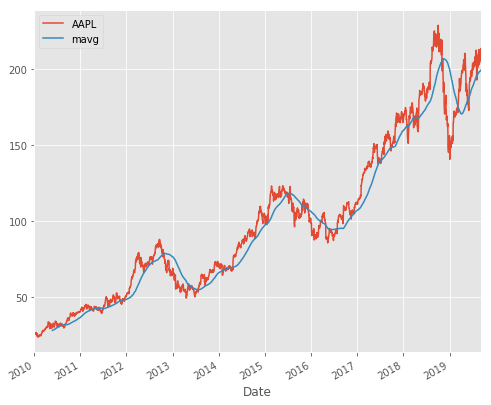

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

#Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize = (8, 7))
mpl.__version__

#Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()


#Expected Return

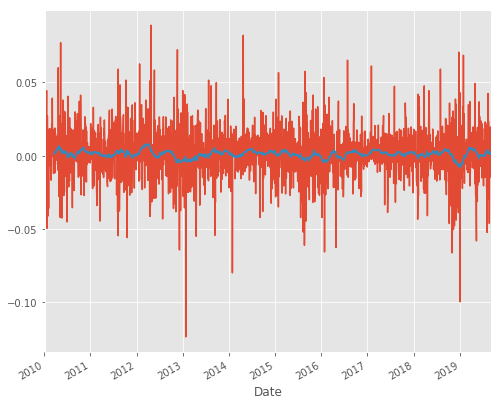

In [0]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label = 'return')
mavg_rets = rets.rolling(window=50).mean()
mavg_rets.plot(label = 'mavg return')


#Analysing your Competitors Stocks

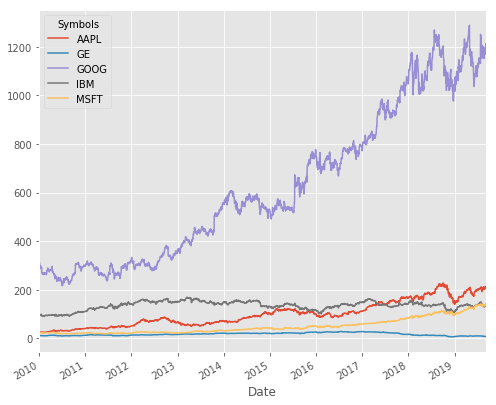

In [0]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'], 'yahoo', start = start, end = end)['Adj Close']


dfcomp.plot()


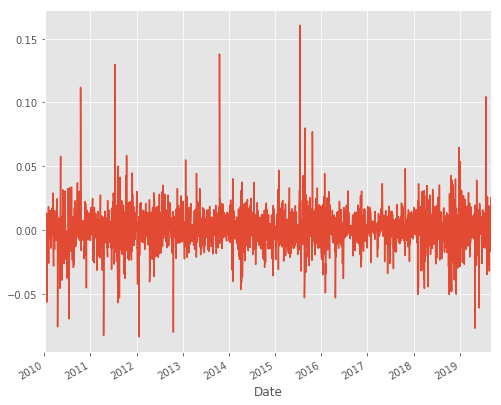

In [0]:
rets_GOOG = dfcomp.GOOG / dfcomp.GOOG.shift(1) - 1
rets_GOOG.plot()

#Correlation Analysis

In [0]:
retscomp = dfcomp.pct_change()
corr = retscomp.corr()
corr.tail(6)

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.000000,0.321280,0.463624,0.386921,0.458291
GE,0.321280,1.000000,0.332088,0.437627,0.361763
GOOG,0.463624,0.332088,1.000000,0.407711,0.539266
IBM,0.386921,0.437627,0.407711,1.000000,0.492707
MSFT,0.458291,0.361763,0.539266,0.492707,1.000000


#RETURN Correlations

Text(0, 0.5, 'Returns GE')

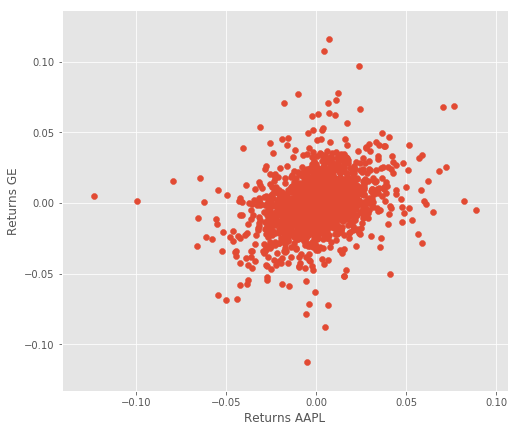

In [0]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

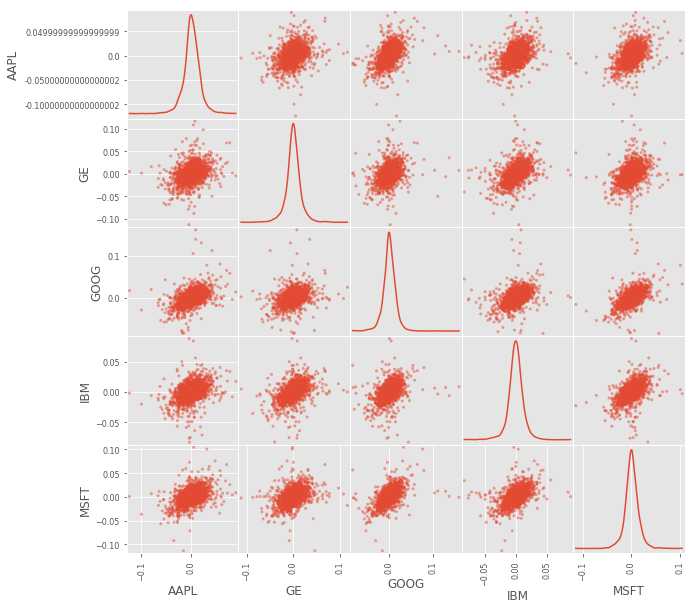

In [0]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));


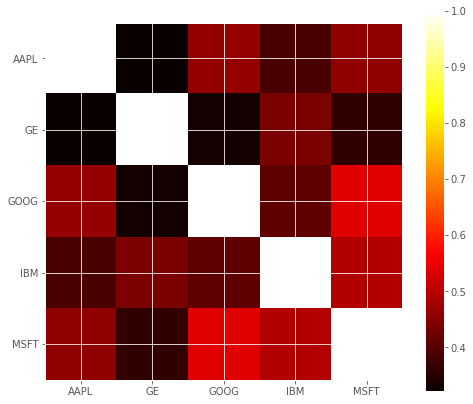

In [0]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

#Returns Rate and Risk analysis

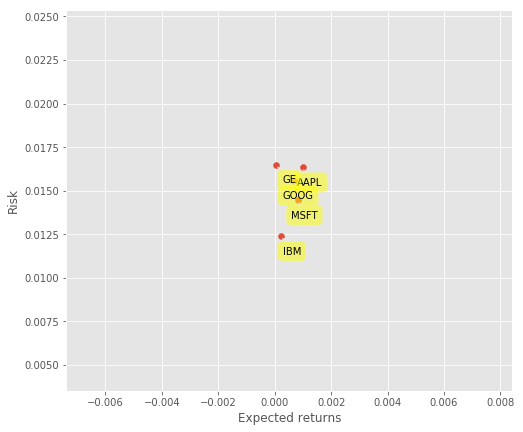

In [0]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

#Predicting Stocks Price

## Feature engineering

In [0]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HT_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

dfreg.tail()

,Adj Close,Volume,HT_PCT,PCT_change
Date,,,,
2019-08-30,208.740005,21143400.0,1.556961,-0.675675
2019-09-03,205.699997,20023000.0,1.341757,-0.353629
2019-09-04,209.190002,19188100.0,1.032549,0.383897
2019-09-05,213.279999,23913700.0,1.153417,0.603773
2019-09-06,213.259995,19350800.0,0.895622,-0.369077


## Pre-processing & Cross Validation
---
1.   Drop missing value
2.   Separating the label here, we want to predict the AdjClose
3.   Scale the X so that everyone can have the same distribution for linear regression
4.   Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
5.   Separate label and identify it as y
6.   Separation of training and testing of model by cross validation train test split



In [0]:


# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

# Model generation
## Import from sklearn

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Linear and Polynomial Regressions models

In [0]:
# Linear regressionon 
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X_train, y_train)

## K Nearest Neighbor (KNN)

